# Paper Implementation - ResNet
Hello, this is my first milestone project in `vision_leaner` - implementing and training ResNet from the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf). I will focus on the ResNet18 architecture, the smallest one introduced in the model (due to computing power constraint). The tasks for me in the notebook will be:

1. Explain the paper.
2. Implement the architecture of ResNet18.
3. Use transfer learning with ResNet18 for the classification task of the dataset [Food101](https://www.kaggle.com/datasets/kmader/food41)

First, let's read the paper.

## 1. Reading the paper


Last time, at TinyCNN, we visited the basic building blocks of CNN - convolution ([torch.nn.Conv2d()](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) and pooling ([torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)). We built the basic architecture, TinyVGG and used it for the task of classifying kanji characters with much better results than the traditional dense model.

CNN went on to be the standard for the time, evident at ImageNet competitions through the years. The trend from 2012 to 2014 competitions suggested that the depth of the model (i.e. how many layers it has) is a crucially benefitting factor. However, there is a *degradation* that haunts deeper model: for some strange reason, accuracy decreases rapidly as a model gets deeper. This sounds like an overfitting problem, except it is not.

![](https://ar5iv.labs.arxiv.org/html/1512.03385/assets/x1.png)

(*Overfitting is testing accuracy getting worse while training accuracy getting better with depth. Here, both testing and training accuracy go down with depth.* [*Source*](https://arxiv.org/abs/1512.03385))

The authors of the paper above argued that the problem was deeper model was harder to train. One aspect of this was reflected in the *vanishing gradient* problem, where the gradients of parameters get so close to zero that the parameters cannot be further updated while optimal solution may yet to be reached. One solution to this problem is normalized initialization, which makes sure the initial weights of the model fall not too far around a mean of 0 (especially for large model).

In theory, a deeper model must perform at least as well as a shallower model (given the deeper model is the shallower model, with more layers stacked on): if anything, the corresponding layers of the deeper model can learn the same weight as the shallower model, while the additional layers learn the *identity function* i.e. makes output equal inputs. In reality, this just did not happen. Part of the reason may come from the normalized initialization: having the weights, which multiply with inputs, fall closely around 0 may make the model likely to output 0, while identity should make you thing of having weights around 1.

(Disclaimer: I got introduced to this idea throught the [video](https://www.youtube.com/watch?v=GWt6Fu05voI&t=470). The idea was not explicitly mentioned in the original paper, and dubious in terms of maths, but it helps me with understanding the problem as well as the solution. Read on.)

Thinking about it, what we want to do is outputting correct label for images that, and to do so by having the stacked layers fit the desired mapping. it also means we want to minimize the difference between the predicted label and the real ones, and may do so by minimize the difference between the learnt layers and the desired layers i.e. making the *residual* as close to 0 as possible. For the weights that already fall closely around 0, this seems like an easier task. Having the weights of a model learn to minimize the residual instead has the potential to solve this degradation problem, and the author did just that. The solution proposed in the paper, taking advantage of the weights normalized around 0, is *adding residual connections to the architecture*.

![Residual learning: a building block](https://ar5iv.labs.arxiv.org/html/1512.03385/assets/x2.png)

(*Instead of learning weights correct for mappings, the model now learns the correct weights for making residual 0.* [*Source*](https://arxiv.org/abs/1512.03385))

ResNet went on to win the 2015 ImageNet competition. The model was easier to train, has fewer parameters (*"...the 152-layer ResNet (11.3 billion FLOPs) still has lower complexity than VGG-16/19 nets (15.3/19.6 billion FLOPs)."*), and better, can scale almost infinitely (see: ResNet-1202, where the authors can finally achieve overfitting).

Back to now, the latest approach is Vision Transformer, with much research *"...aims to surpass and ultimately replace convolutional neural networks (CNNs)"* ([source](https://www.deeplearning.ai/the-batch/issue-176/)), CNN seem here to stay with the trend to incorporate CNN and Transformer to enjoy the best of both worlds: considering relationships between all pixels at both small and large scales of transformer while requiring less data with the local context window and weight sharing of CNN ([source](https://www.deeplearning.ai/the-batch/issue-176/)).

Now let's jump into the code.

## 2. Implementing the architecture:

The implementation idea came from [Aladdin Persson](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/CNN_architectures/pytorch_resnet.py).

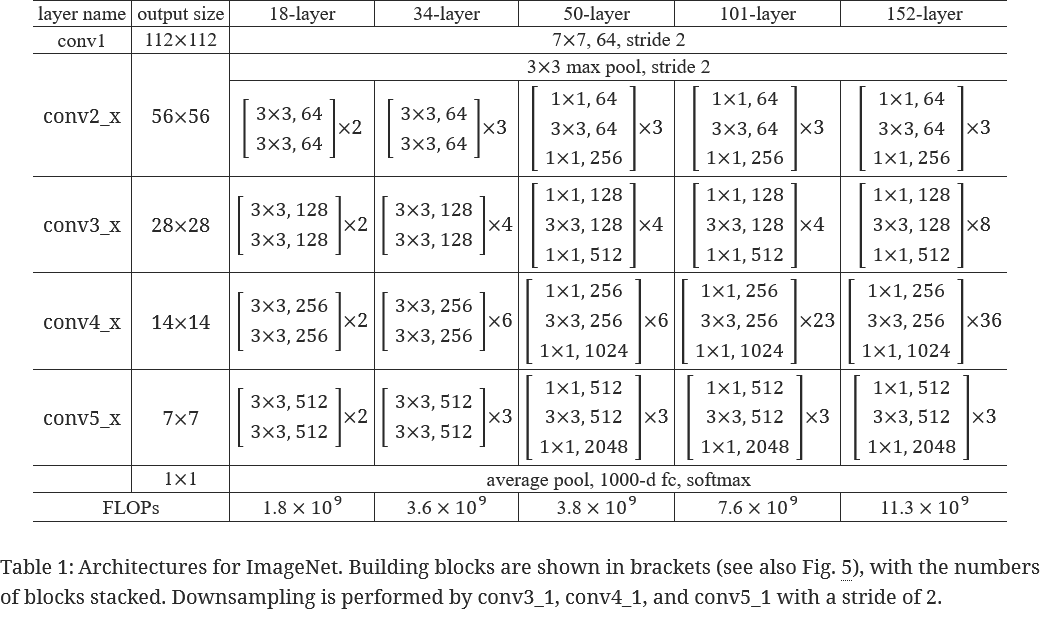

[*Source*](https://arxiv.org/abs/1512.03385)

First, let's check out the implementation in PyTorch.

In [1]:
import torch
from torch import nn

from torchvision import models

/usr/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model = models.resnet18(weights=None)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Okay, it looks hard and complicated. Looking inside and at the table, we see that the layer can be separated into different BasicBlock, which in turn consists of convolutions stacked together with identity downsample at the beginning of the first BasicBlock starting from layer 2 to change the shape. We can start by defining `BasicBlock()` class.

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None, stride=1) -> None:
        super().__init__()
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)
        
        x += identity
        return x

Let's take a look through the codes. The `__init__()` method helps us define the two convolution layers, two batch normalization layers, and one RELU layer. The `downsample` argument is use to construct the downsample layer when needed, whose detail will be specified in the `ResNet()` class.

The skip connection is detailed in the forward function, where, instead of returning the result after passing the input through all the layers, we return the result plus the input. Now let's turn to the `ResNet()` class.

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes) -> None:
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Construct the four layers of ResNet18:
        self.layer1 = self._make_layer(
            block, layers[0], out_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], out_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], out_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], out_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x
    
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels: # Stride is 2 only when we need to reshape inputs
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(
            block(self.in_channels, out_channels, downsample, stride)
        )
        
        self.in_channels = out_channels

        # Create the remaining layers:
        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

Our class relies on a non-public method `_make_layer()` to create the convolution blocks. The `stride` argument is used to specify whether we need to perform downsampling or not.

The implementation above is applicable to both ResNet-18 and ResNet-34. ResNet-50 and deeper rely on a differen `Bottleneck()` architecture.

In [13]:
def ResNet18(num_classes, img_channel=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], img_channel, num_classes)

def ResNet34(num_classes, img_channel=3):
    return ResNet(BasicBlock, [3, 4, 6, 3], img_channel, num_classes)

In [14]:
model = ResNet18(101)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

Results look good!

## 3. Transfer learning

Here's a catch: unless you are trying to do something completely, you will not want to start with a model from scratch. Lower levels of a CNN will learn low-level concept such as edges or curves, which are kind of universally applicable to problems. Therefore, if we have access to the weights of the model previously trained on a related task, we now only need to adapt the higher levels of the model to our task, and we can save a lot of time. That is called [transfer learning](https://developers.google.com/machine-learning/glossary#transfer-learning).

Here, we *do* have access to the pre-trained weights of ResNet-18 on the ImageNet datasets, a classification task with millions of images that can be considered general enough to be useful. Let's apply transfer learning now.

In [15]:
del model

In [16]:
model = models.resnet18(weights=models.ResNet18_Weights)

/usr/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.5MB/s]


In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Okay, the pretrained model has been downloaded!

In transfer learning, we divide the model into two parts: *feature extractor layers* and *classifier* (more generally *head*) layer(s). We want to freeze the parameters of the former while adjusting the later.

In [18]:
for param in model.parameters():
    param.requires_grad = False

Now PyTorch no longer keeps track of the gradients of the parameters, so it will be 0, and the parameters are unchanged udring training. Next, we want to adjust the `fc` layer.